# Google colab setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/computerVision/Cw' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CW_Dataset.zip', '.ipynb_checkpoints', 'HOG_SVM.joblib', 'HOG_MLP.joblib', 'HOG_RFC.joblib', 'SIFT_MLP.joblib', 'SIFT_RFC.joblib', 'test', 'Kmeans.joblib', 'ZIFT_SVM', 'ZSIFT_SVM', 'SIFT_SVM.joblib', 'EmotionRecognition.ipynb', 'training_SIFT_models.ipynb', 'Untitled0.ipynb', 'training_HOG_models.ipynb']


In [ ]:
!pip install opencv-python==4.4.0.46

     |████████████████████████████████| 49.5MB 85kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


# Introduction
This file contains all the classification models trainied with the HOG feature descriptors. 
the process involves :



1.   unzipping the files
1.   loading the dataset
1.   extracting HOG feature descriptors of the dataset
2.   training the classifier
3.   evaluating the classifier
4.   Hyper-parameter tuning
5.   Evaluation after tuning
6.   save the best classifier model







# Loading and preparing the Dataset
this involves loading the train set and test sets and extracts HOG features descriptors.



## unzipping the dataset on colab

zipped dataset is unziped directly on the colab server for faster data accessing 

In [ ]:
#code adapted from lab 7 
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')
# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

In [ ]:
#import messesary libraries
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from joblib import dump, load
from skimage.feature import hog
from skimage import data, exposure

%matplotlib inline

## Importing the train dataset

In [ ]:
# function to load and return images data and labels
def import_dataset(images_path, label_path):
  images_list = []  # empty images list
  labels_list = [] # empty label list
  #read all the image files
  for file in sorted(os.listdir(images_path)):
    if file.endswith('.jpg'):
      image = io.imread(os.path.join(images_path,file))     #read the image
      images_list.append(image)    #add it to the images list

  
  #get the labels for each image from the txt file  

  data = np.genfromtxt(label_path)    #txt file to np
  labels = data[:,1] 
  labels = labels.astype(int)    #convert label to int
  labels_list = labels.tolist()   #add to the label list

  return images_list, labels_list



In [ ]:
#import training images and corresponding labels from the given files
train_images, train_labels = import_dataset('train','labels/list_label_train.txt')


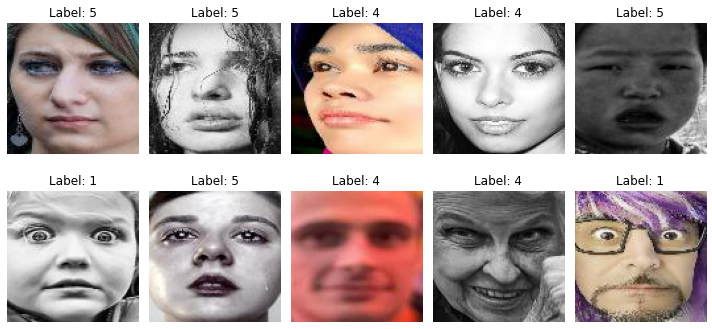

In [ ]:
#display 10 images of the train set
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(train_images[i], cmap='gray')
    ax[i].set_title(f'Label: {train_labels[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()


In [ ]:
#show number of different label classes
unique, counts = np.unique(train_labels, return_counts=True)

print(np.asarray((unique, counts)))

[[   1    2    3    4    5    6    7]
 [1290  281  717 4772 1982  705 2524]]


In [ ]:
print(np.array(train_images).dtype)
print(np.array(train_labels).dtype)


uint8
int64


### HOG feature descriptors extraction

In [ ]:
# adapted from lab 6
#a fuction to return extracted the HOG features from the images and their label
def extract_HOG_featuresDes(images , labels):
  HOG_descriptors=[]
  HOG_images= []
  label_list=[]
 
  for i in range(len(images)):
    image = images[i]
    HOG_des, HOG_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    if HOG_des is not None:
      HOG_descriptors.append(HOG_des)
      HOG_images.append(HOG_image)
      label_list.append(labels[i])
  

  return HOG_descriptors, HOG_images, label_list




In [ ]:
# extracts the hog features of the train dataset
HOG_descriptors, HOG_images, labels = extract_HOG_featuresDes(train_images,train_labels)

In [ ]:
  print(np.array(HOG_descriptors).shape)
  print(len(labels))


(12271, 288)
(12271, 288)
12271


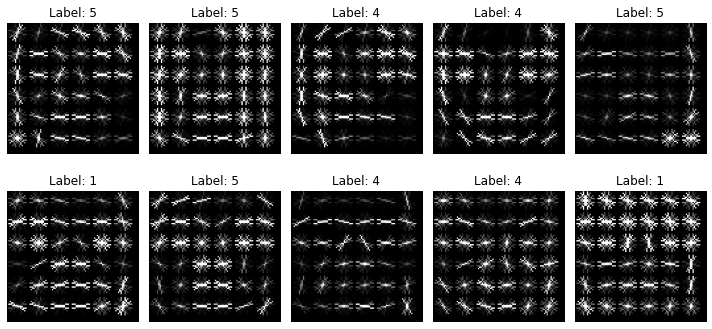

In [ ]:
# plot 10 HOG images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
  
  HOG_image_rescaled = exposure.rescale_intensity(HOG_images[i], in_range=(0, 10))
  ax[i].imshow(HOG_image_rescaled, cmap='gray')
  ax[i].set_title(f'Label: {labels[i]}')
  ax[i].set_axis_off()

fig.tight_layout()
plt.show()
  

In [ ]:
##assinging the X_test and y_test
X_train = HOG_descriptors
y_train = labels

## Loading the Test dataset and extracting HOG features

In [ ]:
# Load the test testdata
test_images, test_labels = import_dataset('test','labels/list_label_test.txt')

In [ ]:
# extracts the hog features of the test dataset
test_HOG_descriptors, test_HOG_images, test_labels = extract_HOG_featuresDes(test_images,test_labels)

# HOG-SVM

## Training the classifier

In [ ]:
# shuffle the dataset to prevent biases,
# by preventing the moddel from learning the order of the training 
X_train , y_train = shuffle(X_train, y_train, random_state=42)

In [ ]:
# SVM classifier with HOG features descriptiors
svm_classifier= svm.SVC( kernel='rbf')
svm_classifier.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Evaluating the trained SVM classifier

In [ ]:
X_test = test_HOG_descriptors
y_test = test_labels

In [ ]:
#predicting the test set on HOG- SVM classifier
svm_predict = svm_classifier.predict(X_test).tolist()


In [ ]:
#printing the classifier scores
print(f"""Classification report for classifier {svm_classifier}:
      {metrics.classification_report(y_test, svm_predict)}\n""")

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
                    precision    recall  f1-score   support

           1       0.59      0.50      0.54       329
           2       1.00      0.15      0.26        74
           3       0.64      0.06      0.10       160
           4       0.73      0.89      0.80      1185
           5       0.56      0.45      0.50       478
           6       0.64      0.33      0.44       162
           7       0.57      0.72      0.64       680

    accuracy                           0.65      3068
   macro avg       0.68      0.44      0.47      3068
weighted avg       0.65      0.65      0.62      3068




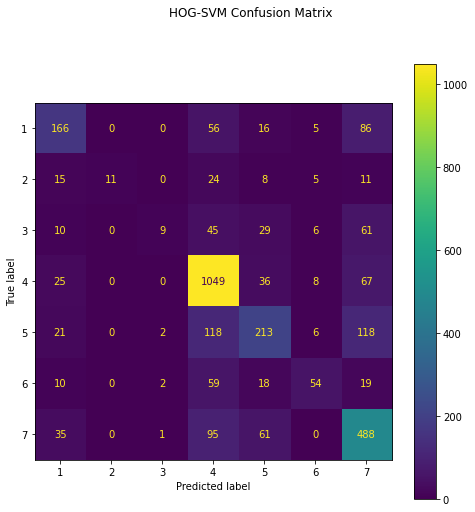

In [ ]:
#displaying the confusion metric of the classifier
#adapted from lab 7
fig, ax = plt.subplots(figsize=(8,8))
disp = metrics.plot_confusion_matrix(svm_classifier, X_test, y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("HOG-SVM Confusion Matrix")
plt.show()

## Improving the SVM classifier
Hyper Parametering tuning with Grid search will be used to improve the classifer by finding the best optimal parameters

### Hyper-Parameter tuning

In [ ]:
# SVM Hyper parameter tuning using GridSearch to find the best optimal Hyper-parameter
#adapted from https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

from sklearn.model_selection import GridSearchCV


# defining parameter range
svm_param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.5, 0.1, 0.01],
              'kernel': ['rbf','poly']} 
#classifier  
svm_grid_classifier = GridSearchCV(svm.SVC(), svm_param_grid, refit = True,cv = 5, verbose = 4)

In [ ]:
  
# traning the classifier with grid parameters
svm_grid_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.389, total= 2.0min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.389, total= 2.0min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.0min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.389, total= 2.0min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.1min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.389, total= 2.0min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.1min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.389, total= 2.0min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.582, total= 1.1min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.601, total= 1.1min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.584, total= 1.1min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.581, total= 1.2min
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ......... C=0.1, gamma=1, kernel=poly, score=0.563, total= 1.2min
[CV] C=0.1, gamma=0.5, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.5, kernel=rbf, score=0.423, total= 1.5min
[CV] C=0.1, gamma=0.5, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 157.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.5, 0.1, 0.01],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5)

In [ ]:
# print best parameter after tuning
print(svm_grid_classifier.best_params_)

print(svm_grid_classifier.best_estimator_)


{'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### Evaluating the tuned HOG-SVM

In [ ]:
# predicting the test set with tuned SVM
svm_grid_predict = svm_grid_classifier.predict(X_test)
  


In [ ]:
print(f"""Classification report for classifier {svm_grid_classifier}:
      {metrics.classification_report(y_test, svm_grid_predict)}\n""")

Classification report for classifier GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.5, 0.1, 0.01],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=5):
                    precision    recall  f1-score   support

           1       0.64      0.47      0.54       329
           2       0.89      0.23      0.37        74
           3       0.48      0.06      0.11       160
           4      

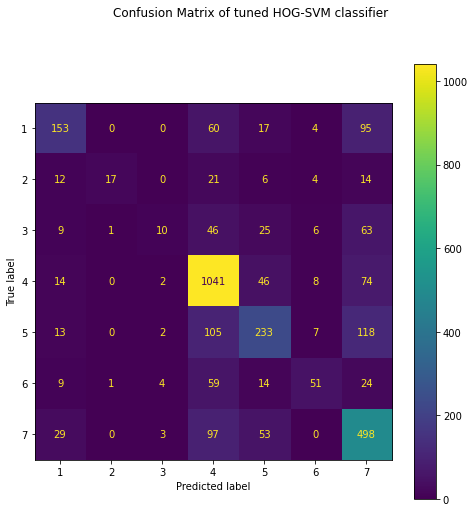

In [ ]:
# confusion metrix of HOG-SVM classifier
fig, ax = plt.subplots(figsize=(8,8))
disp = metrics.plot_confusion_matrix(svm_grid_classifier, X_test, y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix of tuned HOG-SVM classifier")
plt.show()

## Save HOG-SVM classifier
the trained classifier model is saved on the drive with the help of joblib library

In [ ]:
#save the classifier
from joblib import dump
path = os.path.join('drive', 'My Drive', 'Colab Notebooks/computerVision/Cw/HOG_SVM.joblib' )
dump(svm_grid_classifier, path) 

['drive/My Drive/Colab Notebooks/computerVision/Cw/HOG_SVM.joblib']

# HOG-MLP

## Training MLP classifier

In [ ]:
####### HOG MLP classification ##############
#adapted from lab 6
from sklearn.neural_network import MLPClassifier

# MLP, Multi-Layer Perceptron, classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=True, random_state=1,
                    learning_rate_init=.1)



In [ ]:
#fit the train set to the classifier
mlp_classifier.fit(X_train, y_train)

Iteration 1, loss = 1.56084596
Iteration 2, loss = 1.34239014
Iteration 3, loss = 1.27696662
Iteration 4, loss = 1.21141755
Iteration 5, loss = 1.17685217
Iteration 6, loss = 1.15799921
Iteration 7, loss = 1.14091563
Iteration 8, loss = 1.12293305
Iteration 9, loss = 1.11118983
Iteration 10, loss = 1.11561942
Iteration 11, loss = 1.09862704
Iteration 12, loss = 1.09504195
Iteration 13, loss = 1.09493325
Iteration 14, loss = 1.08027140
Iteration 15, loss = 1.08348437
Iteration 16, loss = 1.07569542
Iteration 17, loss = 1.07184980
Iteration 18, loss = 1.07265089
Iteration 19, loss = 1.06364493
Iteration 20, loss = 1.05948383
Iteration 21, loss = 1.06604304
Iteration 22, loss = 1.05665647
Iteration 23, loss = 1.05821496
Iteration 24, loss = 1.04535056
Iteration 25, loss = 1.04780901
Iteration 26, loss = 1.03675610
Iteration 27, loss = 1.04355663
Iteration 28, loss = 1.03693292
Iteration 29, loss = 1.03328824
Iteration 30, loss = 1.02421882
Iteration 31, loss = 1.02701010
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50,), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)

## Evaluating the trained MLP classifier

In [ ]:
# pridict the test set
mlp_predicted= mlp_classifier.predict(X_test)

In [ ]:
# printing the score of the MLP classifier
print(f"""Classification report for classifier {mlp_classifier}:\n
      {metrics.classification_report(y_test, mlp_predicted)}""")

Classification report for classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50,), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=100, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False):

                    precision    recall  f1-score   support

           1       0.64      0.36      0.46       329
           2       0.26      0.23      0.24        74
           3       0.23      0.03      0.05       160
           4       0.57      0.93      0.71      1185
           5       0.50      0.28      0.36       478
           6       0.50      0.26      0.34       162
           7       0.59      0.46      0.52       680

    accuracy     

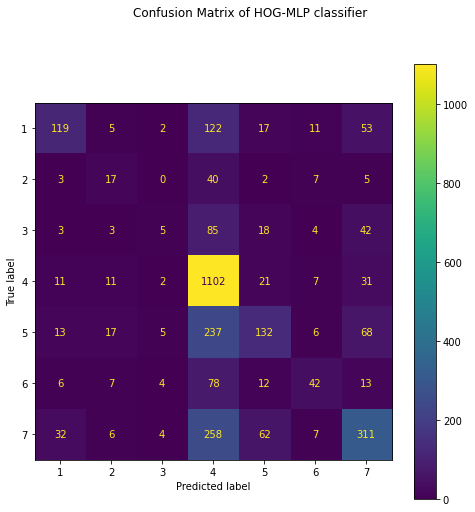

In [ ]:
# confusion metrix of HOG-MLP classifier
fig, ax = plt.subplots(figsize=(8,8))
disp = metrics.plot_confusion_matrix(mlp_classifier, X_test, y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix of HOG-MLP classifier")
plt.show()

## Improving the MLP classifier

### Hyper-Parameter tuning

In [ ]:
# adapted from https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa
#parameters
mlp_param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['adaptive']}

In [ ]:

#classifier  
mlp_grid_classifier = GridSearchCV(MLPClassifier(max_iter=100), mlp_param_grid, refit = True, verbose = 3)

In [ ]:
# fitting the classifier for optimal hyper parameter
mlp_grid_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.3s remaining:    0.0s


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.588, total=  19.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.7s remaining:    0.0s


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.595, total=  19.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.584, total=  19.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.590, total=  18.7s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.584, total=  19.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.597, total=  20.9s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.608, total=  20.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.596, total=  21.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.591, total=  21.2s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.587, total=  20.9s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.591, total=  23.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.596, total=  23.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.589, total=  23.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.595, total=  23.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.586, total=  23.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.599, total=  25.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.612, total=  25.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.594, total=  25.7s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.601, total=  25.8s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.577, total=  25.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.575, total=  15.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.579, total=  15.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.565, total=  15.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.563, total=  15.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.575, total=  15.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.601, total=  16.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.615, total=  16.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.590, total=  12.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.592, total=  16.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.600, total=  16.8s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.591, total=  19.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.604, total=  18.9s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.579, total=  19.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.595, total=  18.7s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.594, total=  18.9s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.595, total=  20.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.617, total=  20.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.580, total=  20.7s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.594, total=  21.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.571, total=  20.9s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.596, total=  23.2s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.599, total=  23.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.588, total=  23.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.585, total=  23.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.593, total=  22.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.605, total=  24.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.601, total=  24.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.588, total=  25.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.597, total=  25.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.595, total=  25.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.573, total=  15.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.584, total=  15.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.566, total=  15.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.566, total=  15.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.585, total=  15.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.607, total=  14.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.617, total=  11.2s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.588, total=  16.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.586, total=  16.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.592, total=  16.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.582, total=  14.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.593, total=  14.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.559, total=  14.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.568, total=  14.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.579, total=  14.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.609, total=  15.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.617, total=  15.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.583, total=  15.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.594, total=  15.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.599, total=  15.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.579, total=  16.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.586, total=  16.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.573, total=  16.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.575, total=  17.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.574, total=  16.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.608, total=  18.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.597, total=  18.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.591, total=  18.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.590, total=  18.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.580, total=  18.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.561, total=  12.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.567, total=  12.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.562, total=  12.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.558, total=  12.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.565, total=  12.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.597, total=  13.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.610, total=  13.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.599, total=  13.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.586, total=  13.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.604, total=  13.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.580, total=  14.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.580, total=  14.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.568, total=  14.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.583, total=  14.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.576, total=  14.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.595, total=  15.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.624, total=  15.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.591, total=  15.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.604, total=  16.1s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.599, total=  15.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.574, total=  17.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.584, total=  17.3s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.573, total=  17.1s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.577, total=  17.2s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.555, total=  17.2s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.606, total=  19.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.616, total=  19.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.581, total=  18.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.590, total=  18.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.606, total=  18.9s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.567, total=  12.2s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.575, total=  12.3s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.563, total=  12.1s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.554, total=  12.1s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, score=0.556, total=  11.9s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.618, total=  13.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.617, total=  13.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.608, total=  13.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.601, total=  13.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 35.1min finished


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, score=0.609, total=  13.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=100, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_st...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['

In [ ]:
# print best parameter after tuning
print(mlp_grid_classifier.best_params_)

# # print how our the classifier looks after hyper-parameter tuning
# print(mlp_grid_classifier.best_estimator_)

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}


### Evaluating the tuned HOG-MLP

In [ ]:
# pridict the test set
mlp_grid_predicted= mlp_grid_classifier.predict(X_test)

In [ ]:
# printing the score of the MLP classifier
print(f"""Classification report for classifier {mlp_grid_classifier}:\n
      {metrics.classification_report(y_test, mlp_grid_predicted)}""")

Classification report for classifier GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=100, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_st...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
    

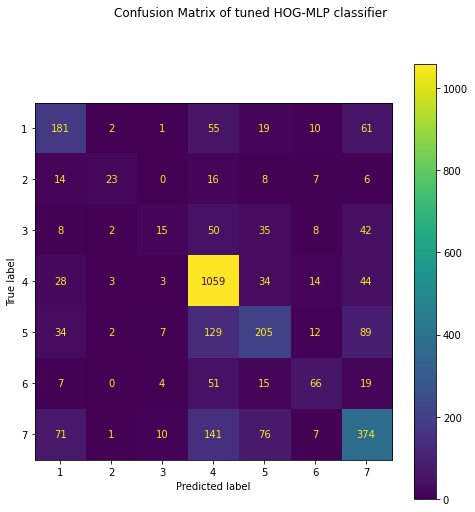

In [ ]:
# confusion metrix of HOG-MLP classifier after grid search
fig, ax = plt.subplots(figsize=(8,8))
disp = metrics.plot_confusion_matrix(mlp_grid_classifier, X_test, y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix of tuned HOG-MLP classifier")
plt.show()

## Save HOG-MLP

In [ ]:
#save the classifier
path = os.path.join('drive', 'My Drive', 'Colab Notebooks/computerVision/Cw/HOG_MLP.joblib' )
dump(mlp_grid_classifier, path) 

['drive/My Drive/Colab Notebooks/computerVision/Cw/HOG_MLP.joblib']

# HOG-Random Forest Classifier

## Training the Random Forest classifier

In [ ]:
########### HOG-RANDOM FOREST CLASSIFIER ################
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()

In [ ]:
#Training the classifier with HOG features descriptors
rf_classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Evaluating the trained Random Forest classifier

In [ ]:
#predicting the test set
rf_predicted = rf_classifier.predict(X_test)

In [ ]:
#eevaluating random forest classifier
print(f"""Classification report for classifier {rf_classifier}:
      {metrics.classification_report(y_test, rf_predicted)}\n""")

Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
                    precision    recall  f1-score   support

           1       0.70      0.22      0.34       329
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       160
           4       0.58      0.92      0.71      1185
           5       0.54      0.22      0.32       478
           6       0.55      0.10      0.17       162
           7       0.50      0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


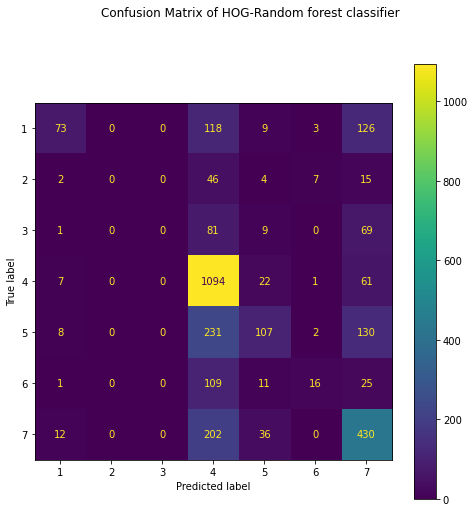

In [ ]:
# confusion metrix of  classifier
fig, ax = plt.subplots(figsize=(8,8))
disp = metrics.plot_confusion_matrix(rf_classifier, X_test, y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix of HOG-Random forest classifier")
plt.show()

## Improving the SVM classifier

### Hyper-Parameter tuning

In [ ]:
# Hyper parameter tuning for random forest classifier using grid search
rf_grid_params = {
    'n_estimators': [10,50,100, 150, 250],
    'min_samples_split': [2, 4, 6]
}


In [ ]:
# finding the best hyper parameter
rf_grid_classifier = GridSearchCV(RandomForestClassifier(), rf_grid_params, cv=5, verbose=5)

rf_grid_classifier.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] min_samples_split=2, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_split=2, n_estimators=10, score=0.460, total=   1.8s
[CV] min_samples_split=2, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=10, score=0.488, total=   1.8s
[CV] min_samples_split=2, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=10, score=0.477, total=   1.8s
[CV] min_samples_split=2, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=10, score=0.480, total=   1.7s
[CV] min_samples_split=2, n_estimators=10 ............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.2s remaining:    0.0s


[CV]  min_samples_split=2, n_estimators=10, score=0.473, total=   1.8s
[CV] min_samples_split=2, n_estimators=50 ............................
[CV]  min_samples_split=2, n_estimators=50, score=0.532, total=   8.8s
[CV] min_samples_split=2, n_estimators=50 ............................
[CV]  min_samples_split=2, n_estimators=50, score=0.549, total=   8.8s
[CV] min_samples_split=2, n_estimators=50 ............................
[CV]  min_samples_split=2, n_estimators=50, score=0.525, total=   8.7s
[CV] min_samples_split=2, n_estimators=50 ............................
[CV]  min_samples_split=2, n_estimators=50, score=0.529, total=   8.6s
[CV] min_samples_split=2, n_estimators=50 ............................
[CV]  min_samples_split=2, n_estimators=50, score=0.532, total=   8.7s
[CV] min_samples_split=2, n_estimators=100 ...........................
[CV]  min_samples_split=2, n_estimators=100, score=0.542, total=  17.2s
[CV] min_samples_split=2, n_estimators=100 ...........................
[CV] 

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 24.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
# print best parameter after tuning
print(rf_grid_classifier.best_params_)

{'min_samples_split': 4, 'n_estimators': 150}


### Evaluating the tuned Random Forest Classifier

In [ ]:
#predicting of test set
rf_grid_predicted = rf_grid_classifier.predict(X_test)

In [ ]:
#printing the score of tuned random forest classifier
print(f"""Classification report for classifier {rf_grid_classifier}:
      {metrics.classification_report(y_test, rf_grid_predicted)}\n""")

Classification report for classifier GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


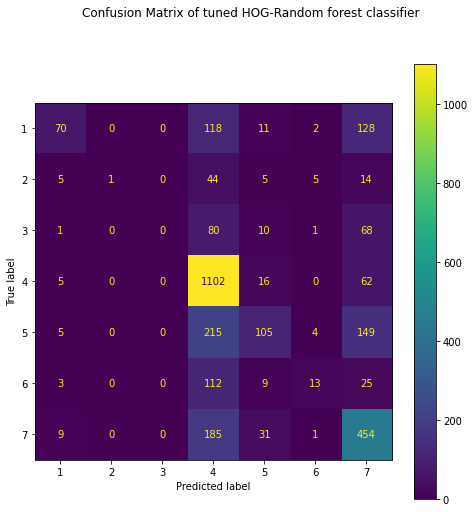

In [ ]:
# confusion metrix of the classifier
fig, ax = plt.subplots(figsize=(8,8))
disp = metrics.plot_confusion_matrix(rf_grid_classifier, X_test, y_test, values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix of tuned HOG-Random forest classifier")
plt.show()

## Save the HOG-Random Forest Classifier

In [ ]:
#save the classifier
path = os.path.join('drive', 'My Drive', 'Colab Notebooks/computerVision/Cw/HOG_RFC.joblib' )
dump(rf_grid_classifier, path)  

['drive/My Drive/Colab Notebooks/computerVision/Cw/HOG_RFC.joblib']